## Travail Personnel 2 : " Traffic flow ".

---


L'objectif de ce nouveau travail personnel est de réussir à modéliser et à décrire le système qu'est le flux de la circulation sur une route à une seule voie.

Pour se faire, nous nous plaçerons ici dans le cas d'un trafic instable pour lequel nous pouvons utiliser l'équation de convection non-linéaire de la densité de voiture. En outre, nous procèderons à 2 simulations distingues afin de mieux comprendre l'évolution de notre système sous différente conditions initiales (CI) et aux bords/limites (CL) pour la densité de trafic. Nous aurons ainsi les 2 ensemble de conditions suivant :

Première simulation :

$$
\left.
    \begin{array}{ll}
         & x = numpy.linspace(0,L,nx)\\
         & rho0  = numpy.ones(nx).10\\
         & rho0[10:20]  = 50\\
    \end{array}
\right \} \text{  (CI) }
$$


$$
\left.
    \begin{array}{ll}
         & \rho(0,t) = 10
    \end{array}
\right \} \text{  (CL)}
$$

Seconde simulation :

$$
\left.
    \begin{array}{ll}
         & x = numpy.linspace(0,L,nx)\\
         & rho0  = numpy.ones(nx).20\\
         & rho0[10:20]  = 50\\
    \end{array}
\right \} \text{  (CI) }
$$


$$
\left.
    \begin{array}{ll}
         & \rho(0,t) = 20
    \end{array}
\right \} \text{  (CL)}
$$

Commençons sans plus tarder par le traitement de nos équations.

##### 1. Traitement des équations.
---

Dans la partie théorique de l'énoncé de ce travail, nous avons vu que le flux, instable, de trafic peut-être modélisé comme la convection non-linéaire de la densité de voiture. Il en découllait donc que l'équation de convection non-linéaire pouvait-être appliqué pour nous donner :

\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial \rho} \frac{\partial \rho}{\partial x} = 0\\
\end{align}



où $\hspace{0.5cm}$ $F = V(\rho) \rho = V_{max} \rho (1- \frac{\rho}{\rho_{max}})$

Avec,

$$
\left\{
    \begin{array}{ll}
        &.V  \text{, la vitesse de circulation (en km/h)} \\
        &.V_{max}  \text{, vitesse maximale que peuvent atteindre les}\\
        &\hspace{0.9cm}  \text{voiture lorsque $\rho→0$}\\
        &.\rho \text{, la densité de trafic, c'est à dire le nombre de voiture}\\
        &\hspace{0.9cm}  \text{par unité de longueur de la route (en voiture/km)}\\
        &. \rho_{max},  \text{la densité maximale atteinte lorsque les voiture}\\
        &\hspace{0.9cm}  \text{sont "pare-chocs contre pare-chocs", et à laquelle}\\
        &\hspace{0.9cm}  \text{correspond une vitesse nulle}
    \end{array}
\right.
$$

En appliquant la $règle\ de\ la\ chaîne^{1}$ sur l'équation (1), nous obtenons alors: 

\begin{align}
\frac{\partial \rho}{\partial t} + \frac{\partial F}{\partial x} = 0\\
\end{align}


---
###### [1]. La règle de dérivation des fonctions composées ou "règle de la chaîne" s'énonce comme suit : Soit f une fonction dérivable en a et g dérivable en f(a). Alors la composition g o f est dérivable en a et on a : $(g◦f)'(a) = g'(f(a)) f'(a)$ ou dans la notation de Leibniz si $y=f(x)$ et $u=g(y)$ alors : $\frac{du}{dx}=\frac{du}{dy} \frac{dy}{dx}$


Utilisation de fonctionnalité proposées par sympy : la dérivée.
Import de la librairie

In [ ]:
# Renvois les résultats dans le style "Latex"
from sympy import init_printing
init_printing()

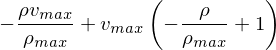

In [11]:
v_max, rho, rho_max = sympy.symbols('v_max rho rho_max')
F = v_max*rho*(-(rho/rho_max)+1)
F


Fprime = F.diff(rho)
Fprime

Que l'on peut réexprimer en mettant $v_{max}$ en évidence et en simplifiant quelque peut les sommes comme suit :

\begin{equation}
v_{max}(1- \frac{2 \rho}{\rho_{max}}) 
\end{equation}

Ainsi, nous avons obtenu grâce à sympy :

\begin{equation}
\frac{\partial F}{\partial \rho} = v_{max}(1- \frac{2 \rho}{\rho_{max}}) 
\end{equation}

L'équation (1) devient alors :

\begin{equation}
\frac{\partial \rho}{\partial t} + v_{max}(1- \frac{2 \rho}{\rho_{max}})  \frac{\partial \rho}{\partial x} = 0\\
\end{equation}

Nous pouvons à présent discrétisé notre equation de convection. Pour se faire, nous utilisons comme demandé dans l'énoncé de ce travail personnel, la "forward-difference" pour la dérivée par rapport au temps et la "backward-difference" pour la dérivée par rapport à l'espace (ici, par rapport à x comme nous travaillons avec une équation à 1 dimension).

Pour rappel, les discrétisations "forward-difference" et "backward-difference" de la dérivée partielle $\partial u/ \partial x$ (par exemple) sont donnée par :

* Forward difference: si on utilise les points $x_i$ et $x_i + \Delta x$ alors la dérivée devient : $\frac{\partial u}{\partial x} \approx \frac{u(x_{i+1})-u(x_i)}{\Delta x}$.
* Backward difference: si on utilise les points $x_i$ et $x_i- \Delta x$ alors la dérivée devient : $\frac{\partial u}{\partial x} \approx \frac{u(x_i)-u(x_{i-1})}{\Delta x}$.

Donc en appliquant ces deux discrétisations à l'équations ( ) il en découle l'équation suivante:

\begin{equation}\frac{\rho_i^{n+1}-\rho_i^n}{\Delta t} + v_{max}(1- \frac{2 \rho_i^{n}}{\rho_{max}}) \frac{\rho_i^n - \rho_{i-1}^n}{\Delta x} = 0, \end{equation}

Où la seule inconnue est $\rho_i^{n+1}$ étant donné nos conditions initiales. En isolant cette inconnue nous obtenons :

\begin{equation}
\rho_i^{n+1}= \rho_i^{n}-\frac{\Delta t}{\Delta x} v_{max}(1- \frac{2 \rho_i^{n}}{\rho_{max}}) (\rho_i^n - \rho_{i-1}^n)
\end{equation}

In [12]:
print(Fprime)

-rho*v_max/rho_max + v_max*(-rho/rho_max + 1)


In [10]:
import numpy
import sympy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16

Après conversion des données dans les unités du Système International:

In [ ]:
v_max = 80*1000/3600   # en m/s
L     = 11000          # en m
rho_max = 250/1000     # en voitures/m
nx    = 51
dx    = 2*numpy.pi/(nx-1)
dt    = .001*3600      # en s

In [ ]:
### Déclaration des variables
nx = 101
nt = 100
dx = 2*numpy.pi/(nx-1)
nu = .07
sigma = .1
dt = sigma*dx**2/nu 

x = numpy.linspace(0, 2*numpy.pi, nx)
un = numpy.empty(nx)
t = 0

x = numpy.linspace(0,L,nx)
rho_0 = numpy.ones(nx)*10
rho_0[10:20] = 50

##### Source:


[1] Cours de MATH-F-101 (Calcul Différentiel et Intégral 1) présenté par M. Joel Fine et M. Denis Bonheure à l'ULB.

---

###### The cell below loads the style of the notebook.

In [2]:
from IPython.core.display import HTML
css_file = '../styles/numericalmoocstyle.css'
HTML(open(css_file, "r").read())